# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import os
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

#### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission = pd.read_csv(get_full_dir('input/playground-series-s3e14/sample_submission.csv'))
df_train = pd.read_csv(get_full_dir('input/playground-series-s3e14/train.csv'), index_col='id')
df_test = pd.read_csv(get_full_dir('input/playground-series-s3e14/test.csv'), index_col='id')
df_og = pd.read_csv(get_full_dir('input/wild-blueberry-yield-prediction-dataset/WildBlueberryPollinationSimulationData.csv'))
df_og.drop('Row#', inplace=True, axis=1)

In [4]:
df_train.isna().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

In [5]:
df_og.isna().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

##### There are no missing values in our train data.

In [6]:
df_sample_submission.head()

,id,yield
0,15289,6025.194
1,15290,6025.194
2,15291,6025.194
3,15292,6025.194
4,15293,6025.194


In [7]:
df_train.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
id,,,,,,,,,,,,,,,,,
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [8]:
df_train.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


In [9]:
df_og.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,18.767696,0.417133,0.282389,0.468817,0.562062,82.277091,49.700515,68.723037,59.309395,28.690219,48.613127,18.309292,0.320000,0.502121,0.445983,36.122432,6012.849165
std,6.999063,0.978904,0.066343,0.161052,0.169119,9.193745,5.595769,7.676984,6.647760,3.209547,5.417072,12.124226,0.171279,0.079445,0.040333,4.377889,1356.955318
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1637.704022
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,3.770000,0.100000,0.454725,0.416281,33.116091,5124.854901
50%,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.508297,0.445587,36.166044,6107.382466
75%,25.000000,0.500000,0.380000,0.630000,0.750000,89.000000,52.000000,71.900000,66.000000,30.000000,50.800000,24.000000,0.390000,0.561297,0.476149,39.239668,7022.189731
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401842


In [10]:
df_test.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
count,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000,10194.000000
mean,19.795958,0.391606,0.286307,0.491328,0.593222,82.207014,49.697204,68.687816,59.256465,28.674779,48.592643,18.507360,0.322501,0.501809,0.446345,36.136349
std,6.591864,0.390022,0.059867,0.148166,0.139897,9.153442,5.552286,7.647629,6.617055,3.198282,5.395790,11.780074,0.165342,0.074707,0.037054,4.019885
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.233554,0.311921,24.320627
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.418867,33.231910
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506346,0.446570,36.013557
75%,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.559325,0.472670,39.127263
max,37.500000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.139425


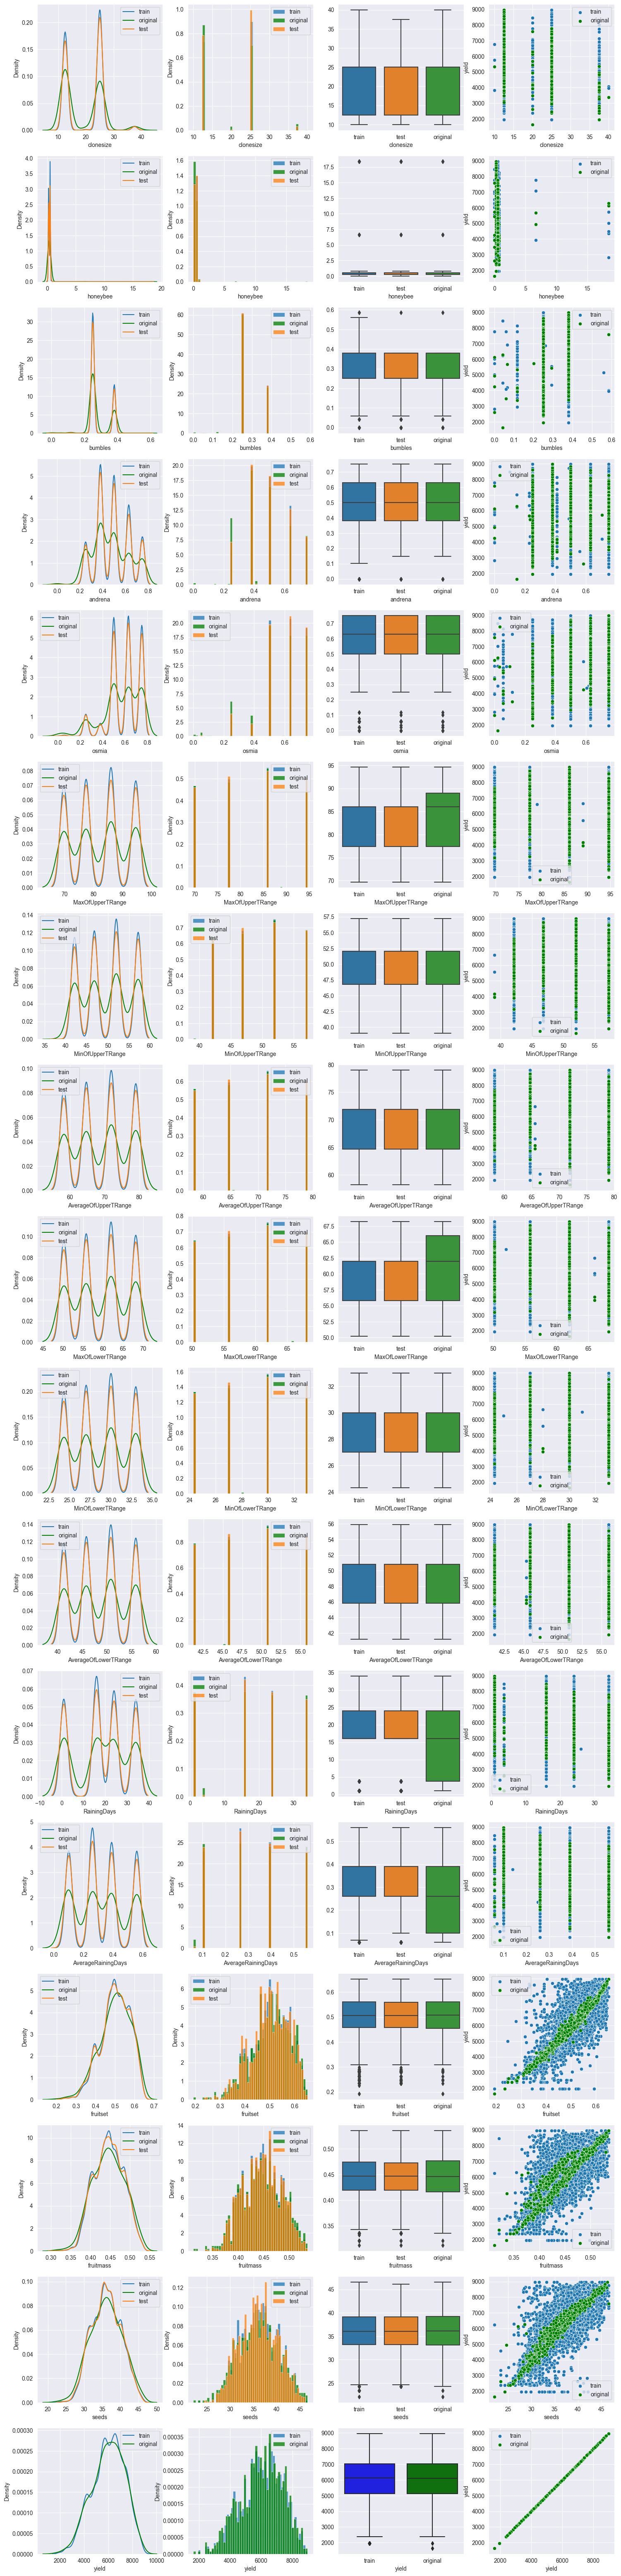

In [11]:
fig, axes = plt.subplots(nrows=len(df_train.select_dtypes(include='number').columns), ncols=4, figsize=(18, 80))
axes = axes.flatten()

i = 0
for col in df_train.select_dtypes(include='number').columns:
    sns.kdeplot(df_train[col], label='train', ax=axes[i], fill=False)
    sns.histplot(df_train[col], label='train', ax=axes[i + 1], stat="density", bins=50)
    sns.kdeplot(df_og[col], label='original', ax=axes[i], fill=False, color="green")
    sns.histplot(df_og[col], label='original', ax=axes[i + 1], stat="density", bins=50, color="green")

    if col != 'yield':
        sns.kdeplot(df_test[col], label='test', ax=axes[i], fill=False)
        sns.histplot(df_test[col], label='test', ax=axes[i + 1], stat="density", bins=50)

    if col != 'yield':
        tmp_data = pd.DataFrame({"train": df_train[col], "test": df_test[col], "original": df_og[col]})
        sns.boxplot(data=tmp_data, ax=axes[i + 2])
    else:
        tmp_data = pd.DataFrame({"train": df_train[col], "original": df_og[col]})
        custom_palette = ["blue", "green"]
        sns.boxplot(data=tmp_data, ax=axes[i + 2], palette=custom_palette)
    axes[i + 2].set_xlabel(col)

    sns.scatterplot(x=col, y="yield", label='train', ax=axes[i + 3], data=df_train)
    sns.scatterplot(x=col, y="yield", label='original', ax=axes[i + 3], data=df_og, color="green")

    axes[i].legend()
    axes[i + 1].legend()
    axes[i + 3].legend()
    i += 4

plt.show()

##### The apper to be some true outliers in the honeybee colum around 18 and 6, the mean for that column is ~0.389

In [12]:
def show_honeybee_outlier_count(df: pd.DataFrame):
    honeybee_data = df['honeybee']
    total = honeybee_data.count()
    below_one = honeybee_data[honeybee_data < 1].count()
    above_17 = honeybee_data[honeybee_data > 17].count()
    one_to_17 = honeybee_data[honeybee_data > 1].count() - above_17
    print(f" Total:\t\t {total}")
    print(f" x < 1:\t\t {below_one}")
    print(f" 1 < x < 17: {one_to_17}")
    print(f" 17 < x:\t {above_17}")

print("Train")
show_honeybee_outlier_count(df_train)
print("Test")
show_honeybee_outlier_count(df_test)
print("Original")
show_honeybee_outlier_count(df_og)

Train
 Total:		 15289
 x < 1:		 15281
 1 < x < 17: 3
 17 < x:	 5
Test
 Total:		 10194
 x < 1:		 10188
 1 < x < 17: 2
 17 < x:	 4
Original
 Total:		 777
 x < 1:		 773
 1 < x < 17: 2
 17 < x:	 2


##### Although the Train and Test datasets have a relatively small number of outliers (8 and 6, respectively), representing less than 0.1% of the datasets, it may still be beneficial to remove them. While outliers can sometimes be genuine observations, they can also have a significant impact on statistical analysis and machine learning models, leading to biased results and poor predictive performance. (Removing the outliers from the train set has improved both evaluation loss and loss on the public set upon kaggle submission)

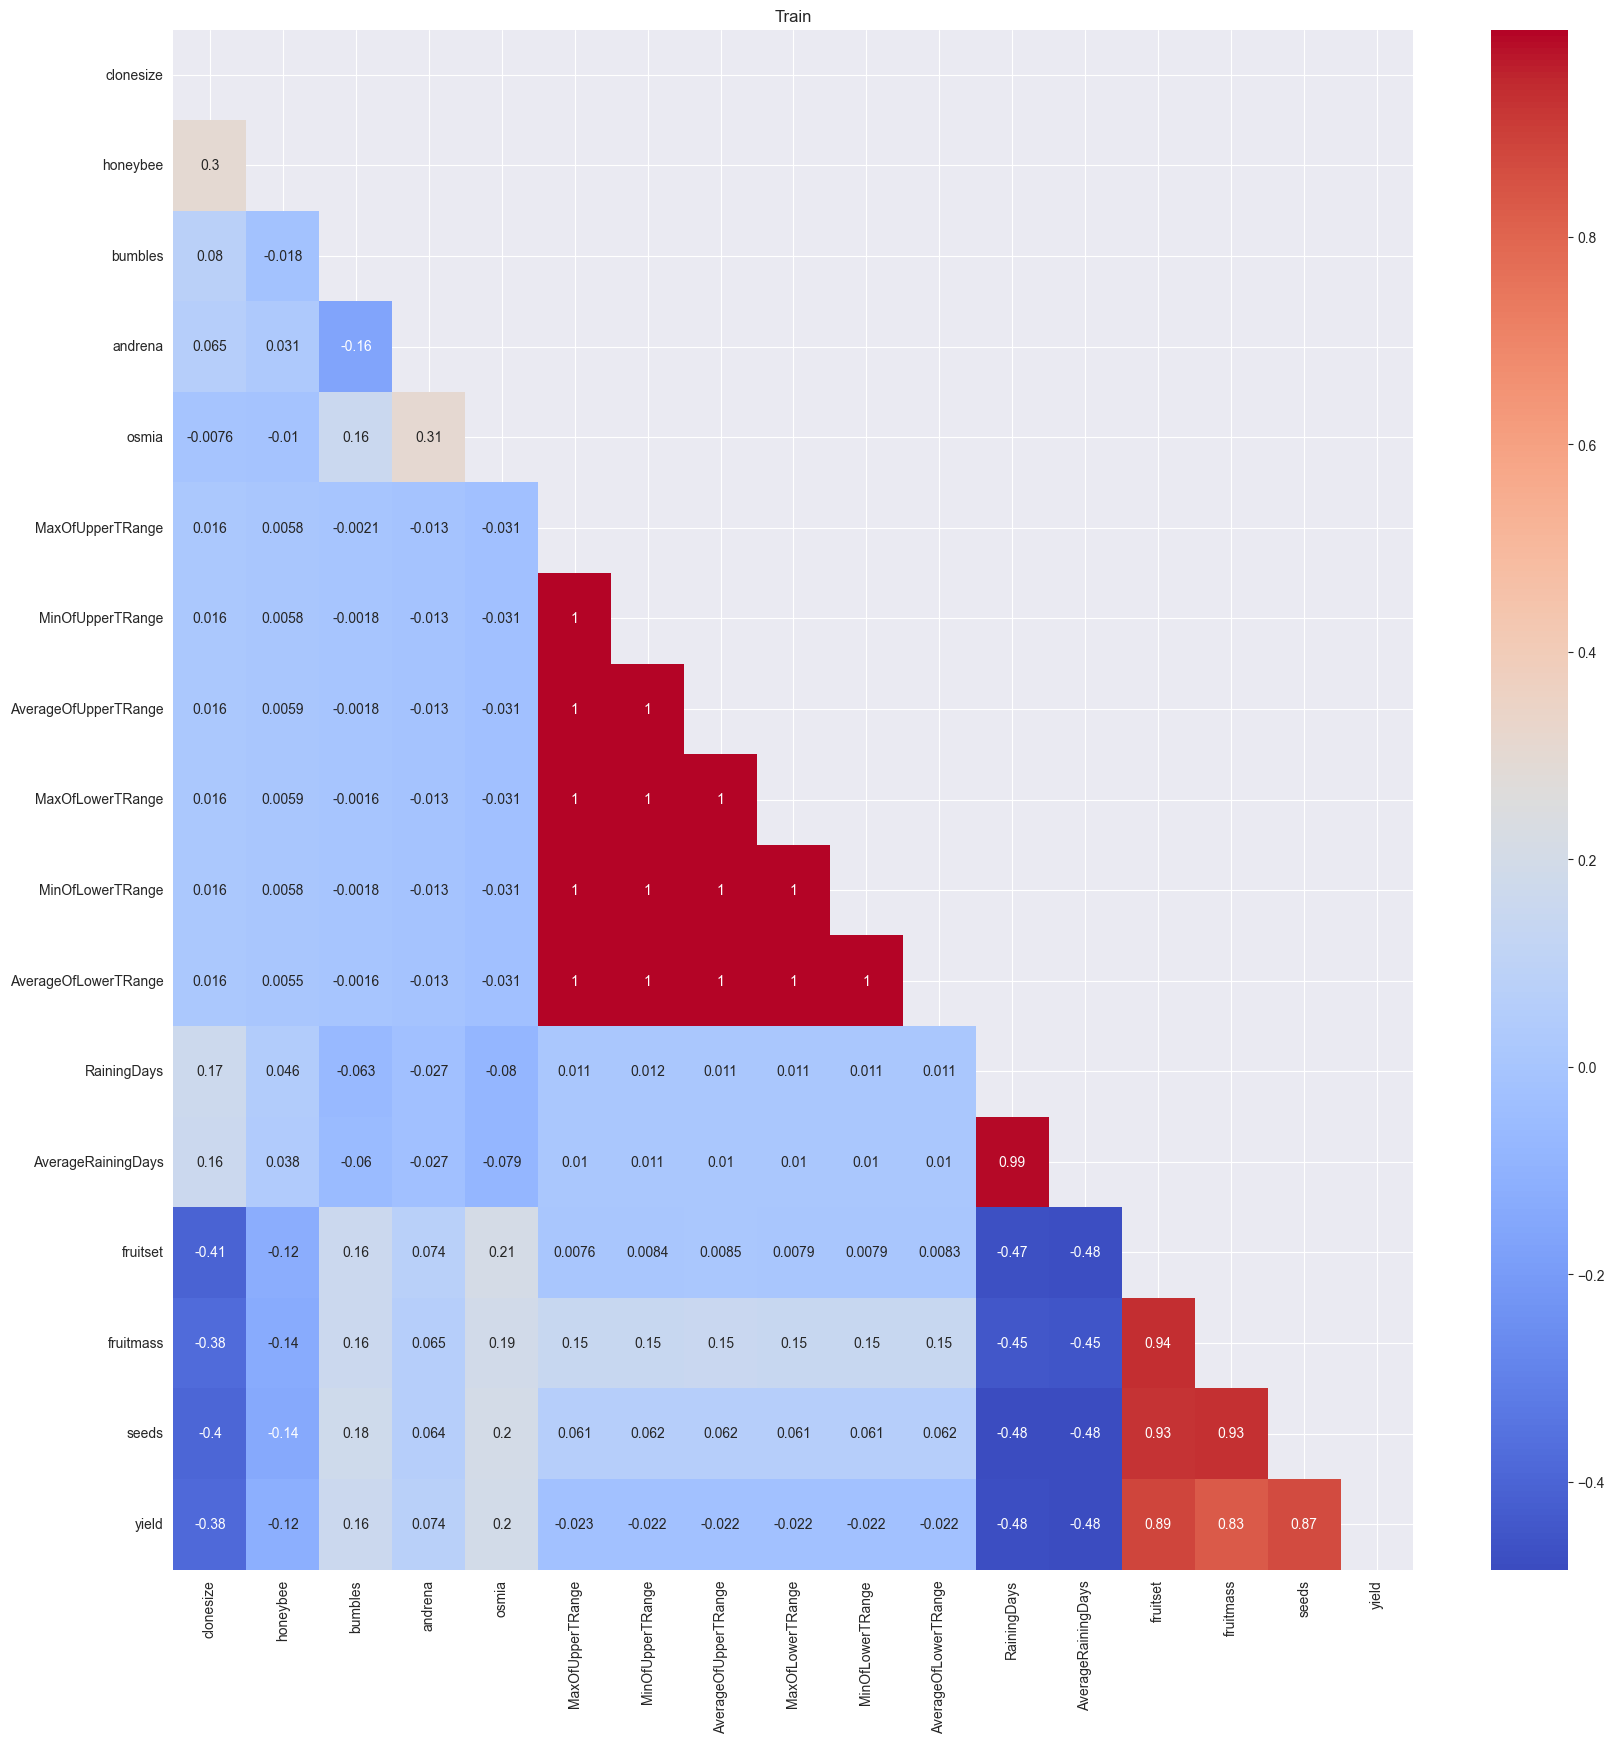

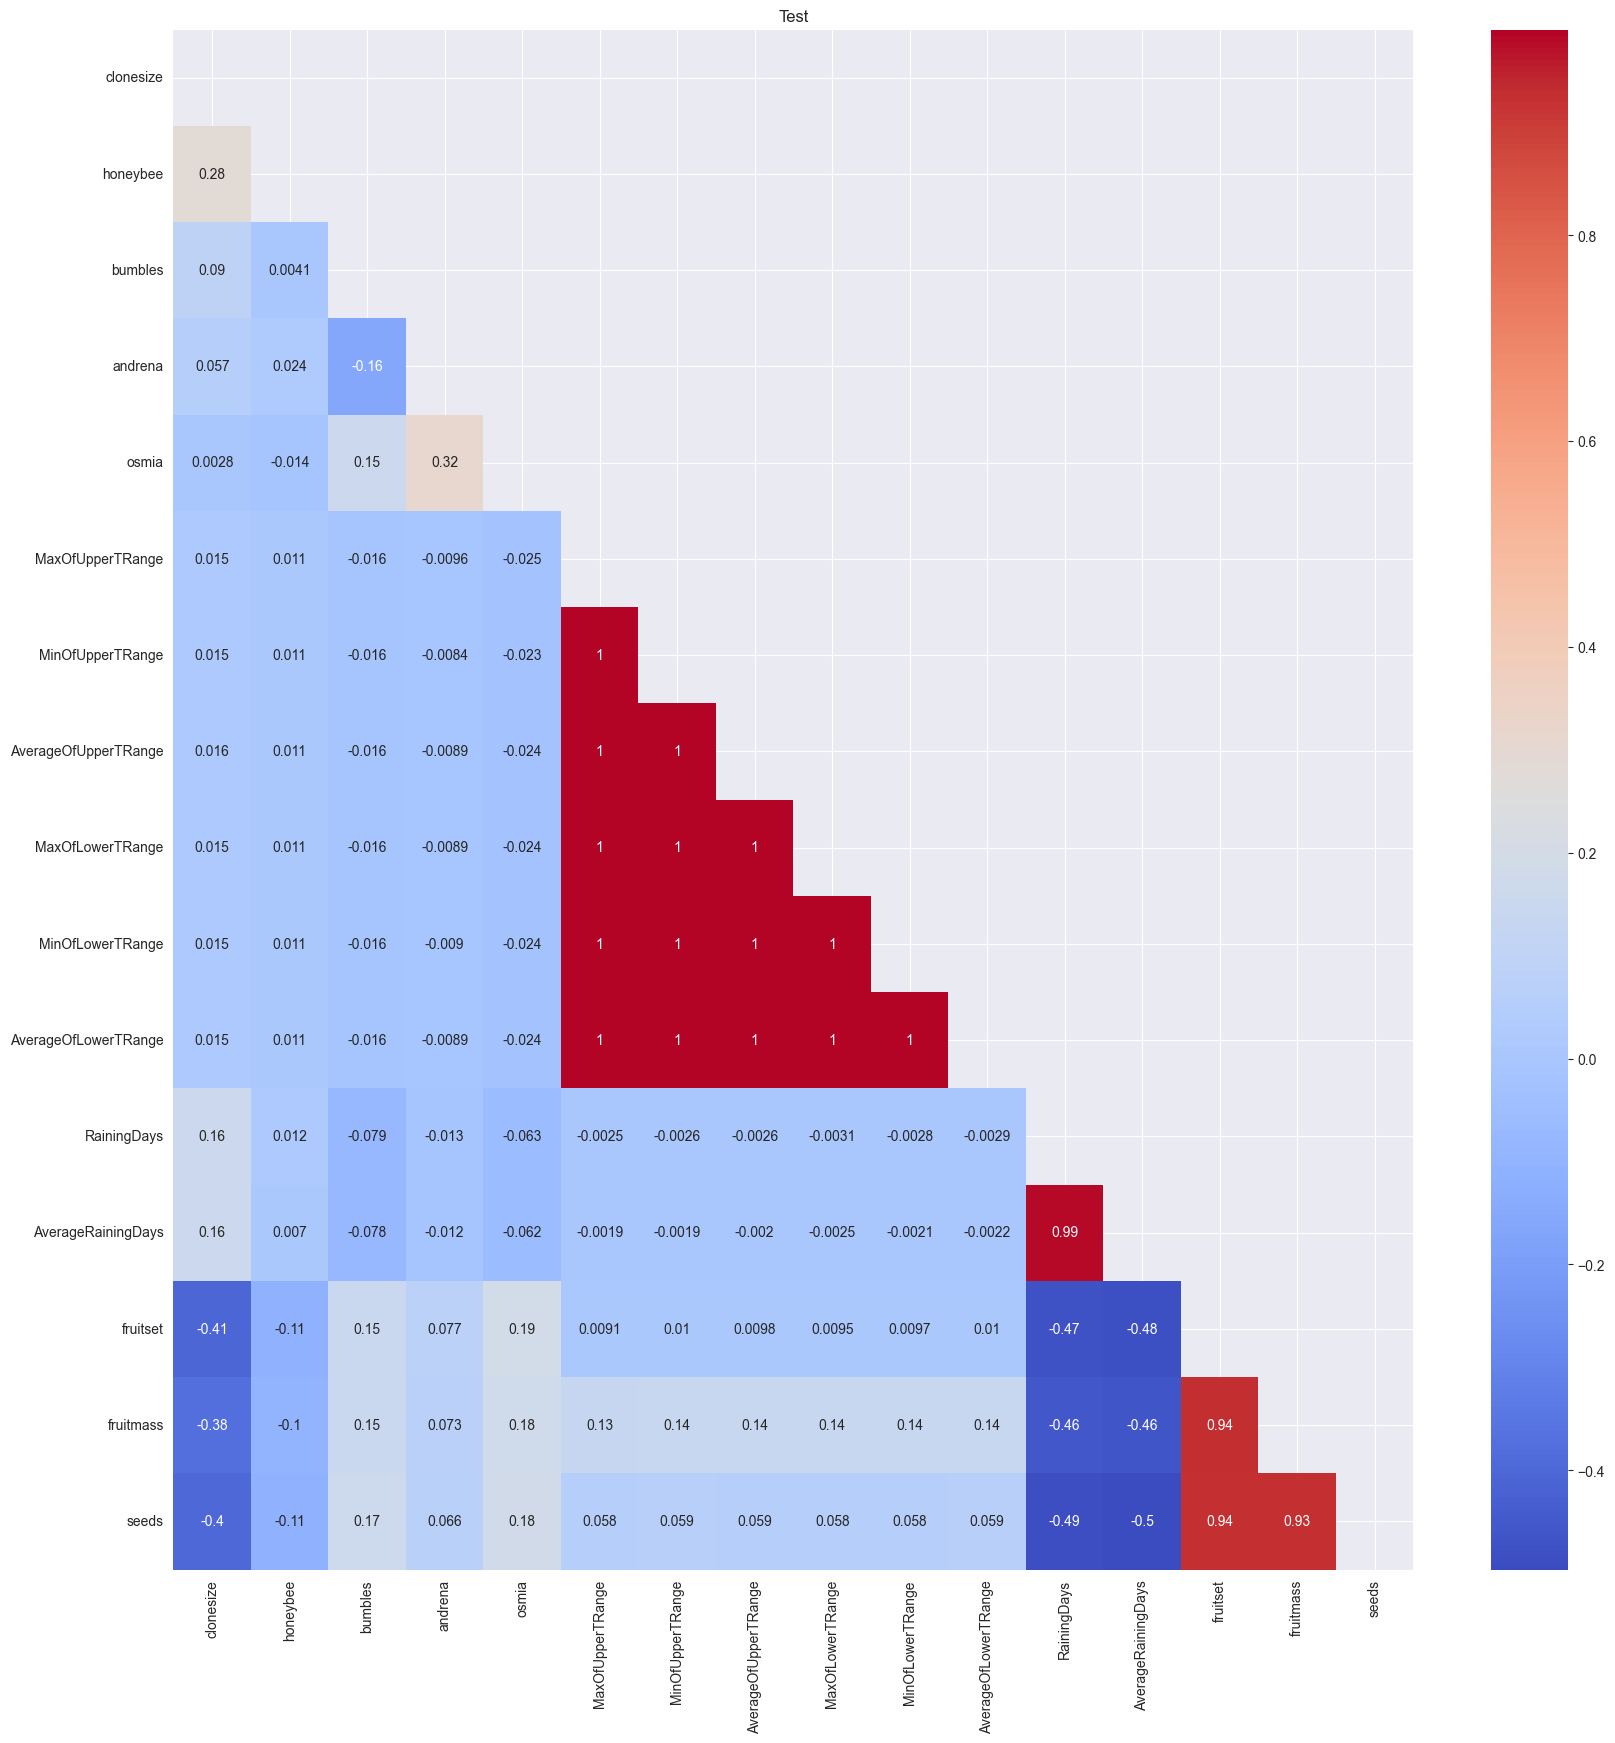

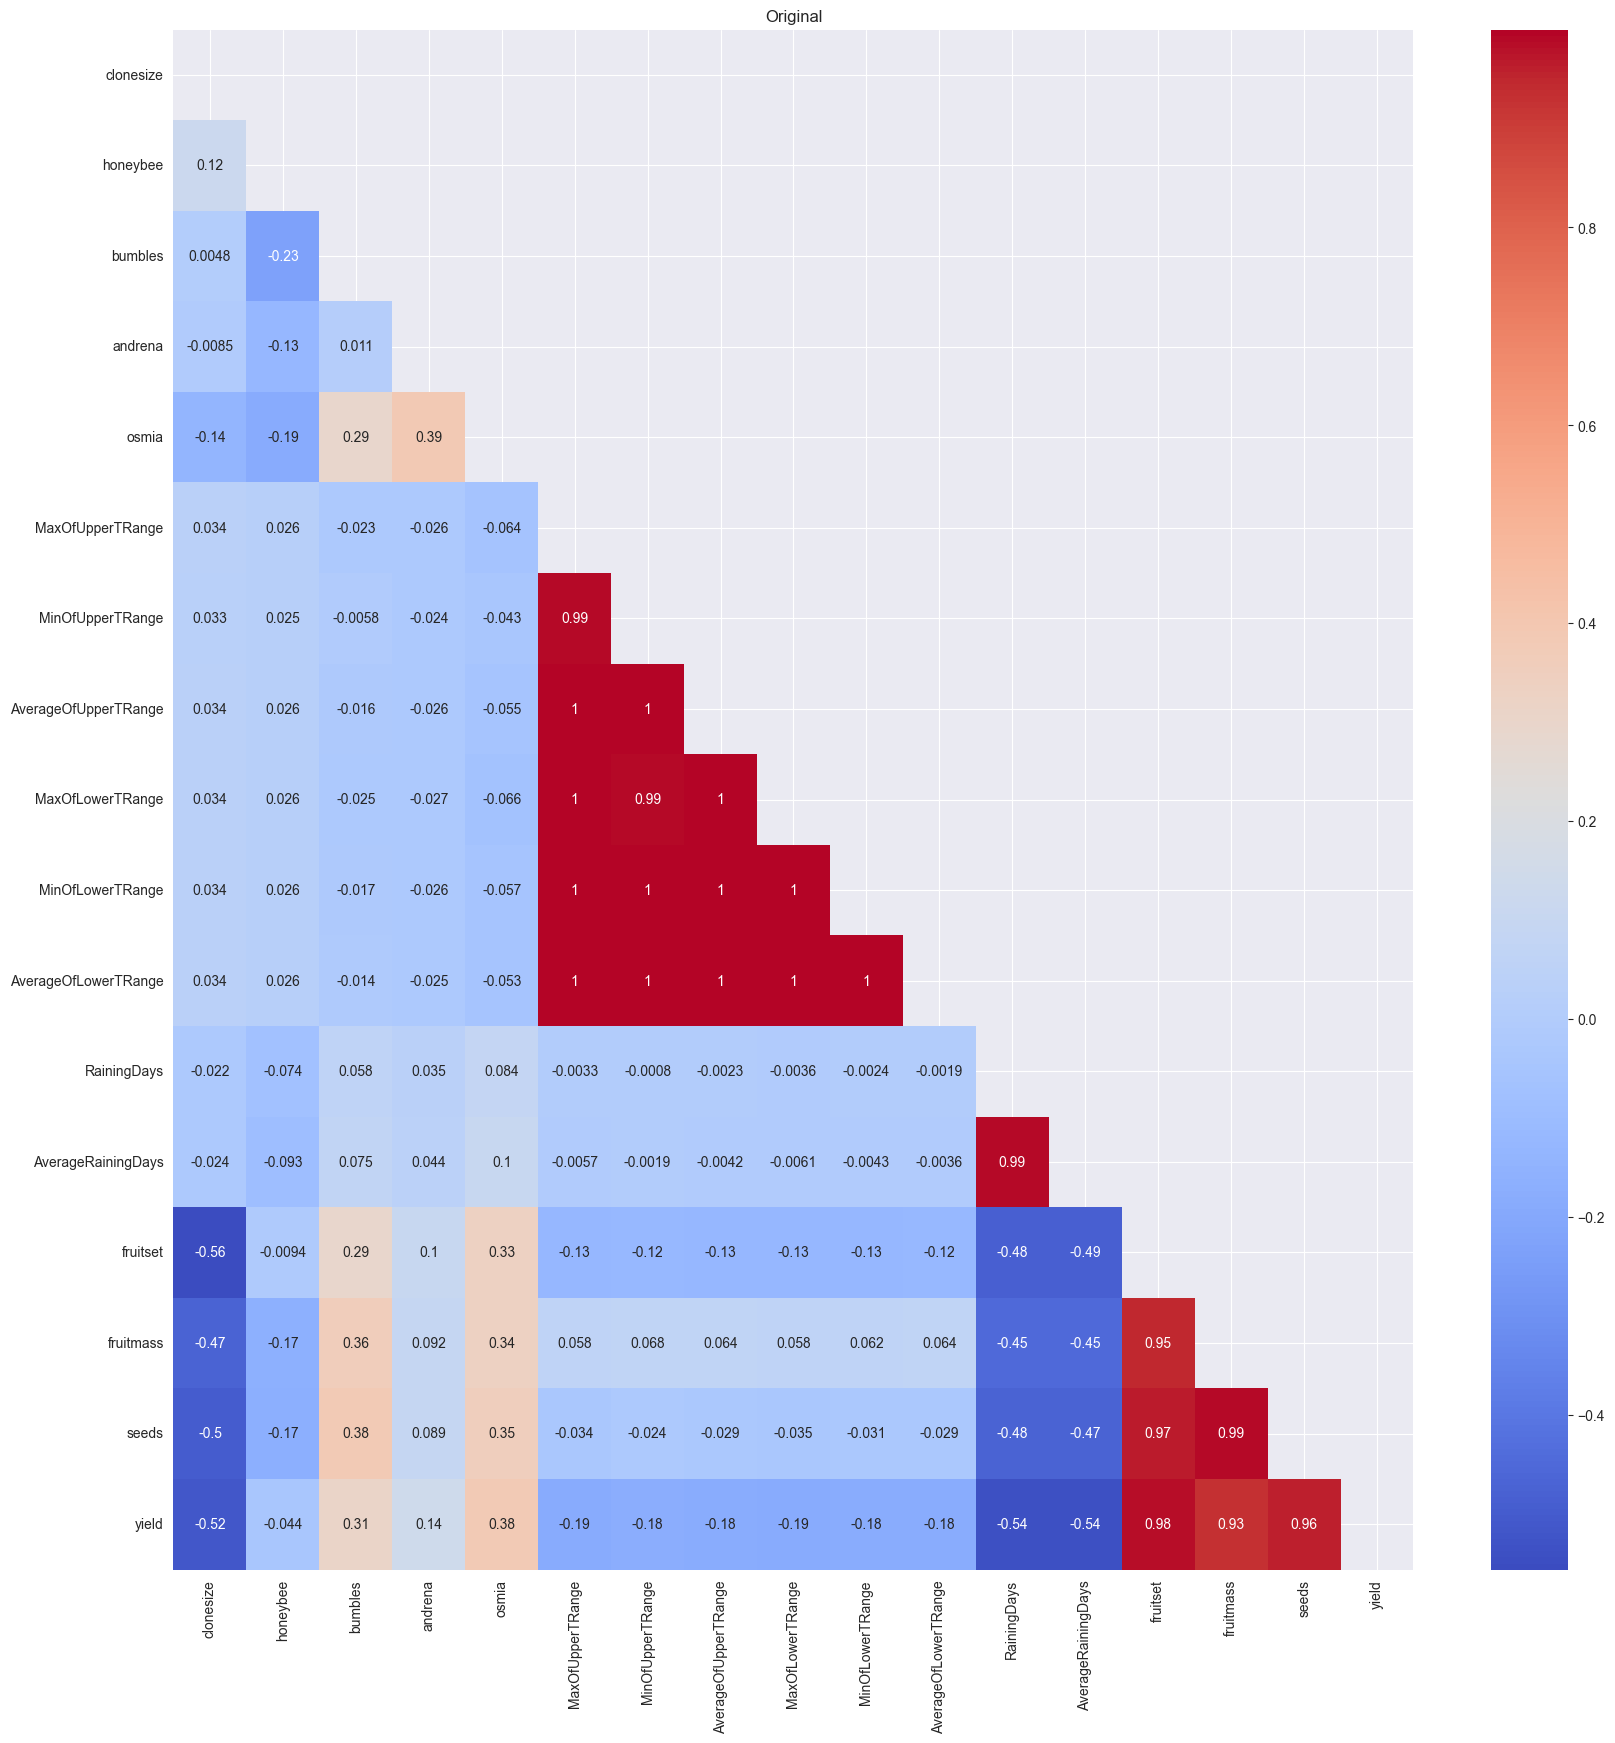

In [13]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(20, 20))
    corr_matrix = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(title)
    plt.show()

show_feature_correlation(df_train, "Train")
show_feature_correlation(df_test, "Test")
show_feature_correlation(df_og, "Original")

##### MaxOfUpperTRange, MinOfUpperTRange, AverageOfUpperTRange, MaxOfLowerTRange, MinOfLowerTRange, AverageOfLowerTRange are all perfectly correlated and AverageRainingDays is almost perfectly correlated to RainingDays.

##### When two or more features in a dataset are highly correlated, they can provide redundant information to the model, which does not add any additional information over the other features. This redundancy can cause instability in the model and lead to biased predictions.

##### Decision tree-based algorithms, such as Random Forest, LGBM and XGBoost, choose a subset of features for consideration at each node. This situation can lead to a bias towards the correlated features, which may negatively impact the model's performance.

##### To mitigate this issue we will remove all but one of the perfectly correlated features. We will remove RainingDays leaving AverageRainingDays and MaxOfUpperTRange, MinOfUpperTRange, AverageOfUpperTRange, MaxOfLowerTRange and MinOfLowerTRange leaving AverageOfLowerTRange


# Prepare data for training

In [14]:
# Handle outliers
use_og_data = True
if use_og_data:
    df_train = pd.concat([df_train, df_og])
#df_train = df_train[df_train['honeybee'] < 1]
df_train.reset_index(drop=True, inplace=True)
#df_test[df_test['honeybee'] > 1] = df_train['honeybee'].mean()

df_train["fruit_seed"] = df_train["fruitset"] * df_train["seeds"]
df_test["fruit_seed"] = df_test["fruitset"] * df_test["seeds"]

df_train["pollinators"] = df_train["honeybee"] + df_train["bumbles"] + df_train["andrena"] + df_train["osmia"]
df_test["pollinators"] = df_test["honeybee"] + df_test["bumbles"] + df_test["andrena"] + df_test["osmia"]

# Remove perfectly correlated features
features_to_remove = ['RainingDays', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'honeybee', 'bumbles', 'andrena' , 'osmia']
df_train.drop(features_to_remove, axis=1, inplace=True)
df_test.drop(features_to_remove, axis=1, inplace=True)
# Scale features
standard_scaler = StandardScaler()
X = df_train.drop(columns=['yield'])
X_scaled = standard_scaler.fit_transform(X)
df_train = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), df_train['yield']], axis=1)
X_scaled = standard_scaler.transform(df_test)
df_test = pd.DataFrame(X_scaled, columns=X.columns)

# Train Models

In [15]:
param_dist_lgbm = {
    'n_estimators': [1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [5, 10, 15, 20, 25],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 1],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 1],
    'num_leaves': [12, 16, 20, 24],
    'objective': ["mae"]
}

param_dist_catboost = {
    'iterations': [1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 5, 6, 7],
    'l2_leaf_reg': [0, 0.01, 0.05, 0.1, 0.5, 1],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bylevel': [0.5, 0.7, 0.9],
    'random_strength': [0.05, 0.1, 0.2],
    'bagging_temperature': [0.1, 0.5, 1],
    'loss_function': ['MAE'],
    'verbose': [False]
}

param_dist_xgboost = {
    'n_estimators': [1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 5, 10, 15, 20],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 1],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 1],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 1],
    'objective': ["reg:squarederror"],
    'eval_metric': ['mae'],
}

In [16]:
def param_search(model, param_space, n_iter) -> RandomizedSearchCV:
    # Load data
    X_train = df_train.copy(deep=True)
    y_train = X_train.pop('yield')

    # Create RandomizedSearchCV object
    rs = RandomizedSearchCV(model, param_distributions=param_space, cv=5, n_iter=n_iter, scoring='neg_mean_absolute_error')
    # Fit the model on the training data
    rs.fit(X_train, y_train)
    # Return results
    return rs

In [17]:
# Best LGBM MAE score: 343.2325960478029
lgb_param = {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0.3, 'objective': 'mae', 'num_leaves': 20, 'n_estimators': 1000, 'min_child_weight': 15, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
# Best LGBM MAE score with og data: 331.42112060877287
lgb_param_og = {'subsample': 0.5, 'reg_lambda': 0.2, 'reg_alpha': 0.2, 'objective': 'mae', 'num_leaves': 20, 'n_estimators': 1000, 'min_child_weight': 20, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
# Best CatBoost MAE score: 343.05477508026945
cat_param =  {'verbose': False, 'subsample': 0.7, 'random_strength': 0.1, 'loss_function': 'MAE', 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 6, 'colsample_bylevel': 0.9, 'bagging_temperature': 1}
# Best CatBoost MAE score with og data: 331.2581516022393
cat_param_og =  {'verbose': False, 'subsample': 0.7, 'random_strength': 0.1, 'loss_function': 'MAE', 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 6, 'colsample_bylevel': 0.7, 'bagging_temperature': 0.5}
# Best XGBoost MAE score: 352.23548398423674
xgb_param = {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.2, 'eval_metric': 'mae', 'colsample_bytree': 0.9}

In [18]:
# Param searches the space
search = False

In [19]:
if search:
    # Defines models
    lgb_model = lgb.LGBMRegressor()
    lgb_rs = param_search(lgb_model, param_dist_lgbm, 50)
    print("Best LGBM parameters:", lgb_rs.best_params_)
    print("Best LGBM MAE score:", -lgb_rs.best_score_)
    lgb_param = lgb_rs.best_params_

    cat_model = CatBoostRegressor(grow_policy='Lossguide')
    cat_rs = param_search(cat_model, param_dist_catboost, 50)
    print(f"Best CatBoost parameters:", cat_rs.best_params_)
    print(f"Best CatBoost MAE score:", -cat_rs.best_score_)
    cat_param = cat_rs.best_params_

    #xgb_model = xgb.XGBRegressor(tree_method = 'gpu_hist')
    #xgb_rs = param_search(xgb_model, param_dist_xgboost, 1000)
    #print("Best XGBoost parameters:", xgb_rs.best_params_)
    #print("Best XGBoost MAE score:", -xgb_rs.best_score_)
    #xgb_param = xgb_rs.best_params_

In [20]:
# Idea source: https://www.kaggle.com/competitions/playground-series-s3e14/discussion/407327
# Implementation source: https://www.kaggle.com/code/paddykb/ps-s3e14-flaml-bfi-be-bop-a-blueberry-do-dah?scriptVersionId=128512560&cellId=7
unique_targets = np.unique(pd.read_csv(get_full_dir('input/playground-series-s3e14/train.csv'), index_col='id')["yield"])
def post_processing_trick(predictions):
    return np.array([min(unique_targets, key = lambda x: abs(x - predictions)) for predictions in predictions])

In [21]:
class Pipeline:

    def __init__(self, model='XGB'):
        self.model_type = model
        if model == 'LGB':
            self.model = lgb.LGBMRegressor(
                #num_leaves = 16,
                #max_depth=5,
                #learning_rate = 0.01,
                #n_estimators=1000,
                #objective = "mae",
                **lgb_param
            )
        elif model == 'CatBoost':
            self.model = CatBoostRegressor(
                grow_policy="Lossguide",
                #iterations=1000,
                #learning_rate=0.01,
                #depth=4,
                **cat_param
            )
        else:
            self.model = xgb.XGBRegressor(
                #objective = 'reg:absoluteerror',
                #tree_method = 'gpu_hist',
                #colsample_bytree = 0.6,
                #gamma = 0.8,
                #learning_rate = 0.01,
                #max_depth = 5,
                #min_child_weight = 5,
                #n_estimators = 1000,
                #subsample = 0.7
                **xgb_param
            )

    def fit(self, X, y, X_val, y_val):
        self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

    def grid_search(self, X, y, X_eval, y_eval):
       pass

In [22]:
def train(model_type):
    X = df_train.drop(['yield'], axis=1)
    y = df_train['yield']
    SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        #train_dataframe = pd.concat([train_dataframe, df_og])
        #train_dataframe.reset_index(drop=True, inplace=True)
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('yield', axis=1)
        y_train = train_dataframe['yield']
        X_dev = dev_dataframe.drop('yield', axis=1)
        y_dev = dev_dataframe['yield']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model=model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [23]:
lossesLGB, pipelinesLGB, eval_sets_LGB = train('LGB')

C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 loss: 320.30541590503276


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 loss: 336.658928484271


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 loss: 336.4125516531326


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 322.29919638298236


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 loss: 340.4116474317347
Mean loss: 331.2175479714307


In [24]:
lossesCB, pipelinesCB, eval_sets_CB = train('CatBoost')

Fold 0 loss: 319.2922633265464
Fold 1 loss: 336.88545131915583
Fold 2 loss: 334.7936795081913
Fold 3 loss: 322.1958935059386
Fold 4 loss: 340.85952417278054
Mean loss: 330.80536236652256


In [25]:
lossesXGB, pipelinesXGB, eval_sets_XGB = train('XGB')

Fold 0 loss: 330.6545934259684
Fold 1 loss: 346.1085655345082
Fold 2 loss: 345.1613943075178
Fold 3 loss: 333.0138791395503
Fold 4 loss: 351.11047792738975
Mean loss: 341.2097820669869


###### Model evaluation on train data only, original data excluded. The original data is a bit easier than the train data inflating the score, loss on train data is almost exactly the same as the public score and view it is beneficial for evaluation purpose.

In [26]:
def get_loss(pipelines, eval_sets_idx, use_postprocessing_trick=False):
    losses = []
    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('yield', axis=1)
        y_dev = dev['yield']
        prediction = pipeline.predict(X_dev)
        if use_postprocessing_trick:
            prediction = post_processing_trick(prediction)
        loss = mean_absolute_error(y_dev, prediction)
        losses.append(loss)
    return np.array(losses).mean()

print(f"LightGBM Validation loss: {np.array(lossesLGB).mean()}, with og data excluded: {get_loss(pipelinesLGB, eval_sets_LGB)}, with postprocessing trick {get_loss(pipelinesLGB, eval_sets_LGB, use_postprocessing_trick=True)}")
print(f"CatBoots Validation loss: {np.array(lossesCB).mean()}, with og data excluded: {get_loss(pipelinesCB, eval_sets_CB)}, with postprocessing trick {get_loss(pipelinesCB, eval_sets_CB, use_postprocessing_trick=True)}")
print(f"XGBoost Validation loss: {np.array(lossesXGB).mean()}, with og data excluded: {get_loss(pipelinesXGB, eval_sets_XGB)}, with postprocessing trick {get_loss(pipelinesXGB, eval_sets_XGB, use_postprocessing_trick=True)}")

LightGBM Validation loss: 331.2175479714307, with og data excluded: 341.8776097478174, with postprocessing trick 341.7910803220992
CatBoots Validation loss: 330.80536236652256, with og data excluded: 341.39878829033034, with postprocessing trick 341.25737181769756
XGBoost Validation loss: 341.2097820669869, with og data excluded: 351.2040223646828, with postprocessing trick 351.09827232816724


# Feature Importance

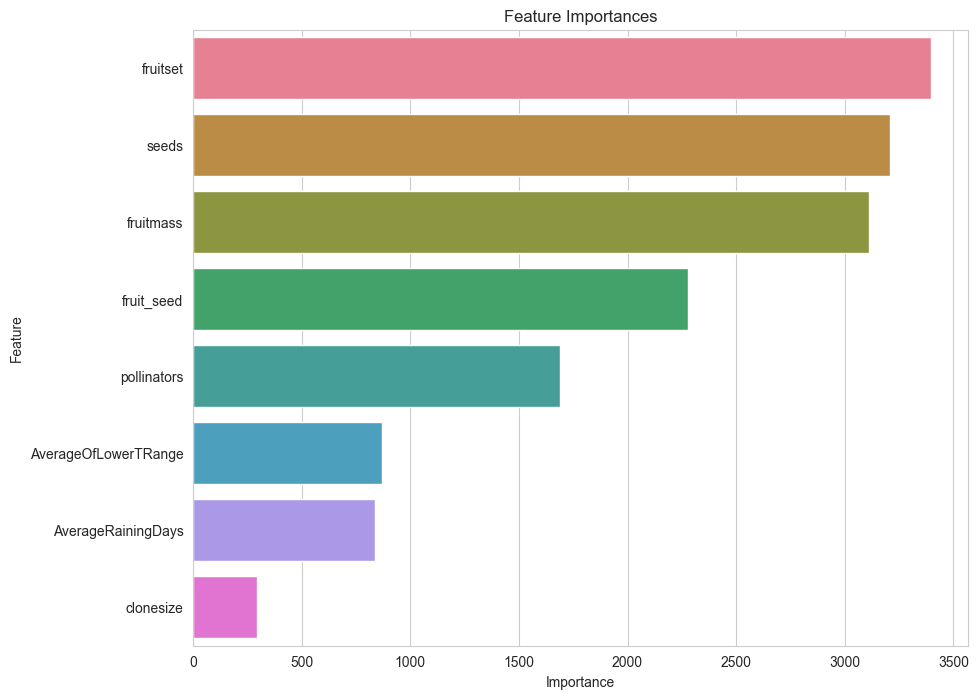

In [27]:
# Get feature importance
importance = pipelinesLGB[0].model.feature_importances_
for i in range(1, len(pipelinesLGB)):
    importance += pipelinesLGB[i].model.feature_importances_
importance = importance / 5.0
feature_names = X.columns.values

# Create a dataframe of feature importance
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
# Sort features by importance
df_importance = df_importance.sort_values('importance', ascending=False)

# Create horizontal bar plot of feature importance
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(df_importance))
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [28]:
def graph_pred_vs_true(pipelines, eval_sets_idx, use_postprocessing_trick=False):
    preds_t = []
    true_t = []
    preds_o = []
    true_o = []
    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev_t = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev_t.drop('yield', axis=1)
        y_dev = dev_t['yield']
        prediction = pipeline.predict(X_dev)
        if use_postprocessing_trick:
            prediction = post_processing_trick(prediction)
        preds_t.append(np.array(prediction))
        true_t.append(np.array(y_dev))

        dev_o = df_train.iloc[eval_set[eval_set > 15281]]
        X_dev = dev_o.drop('yield', axis=1)
        y_dev = dev_o['yield']
        prediction = pipeline.predict(X_dev)
        if use_postprocessing_trick:
            prediction = post_processing_trick(prediction)
        preds_o.append(np.array(prediction))
        true_o.append(np.array(y_dev))

    pt = preds_t[0]
    for i in range(1, len(preds_t)):
        pt = np.concatenate((pt, preds_t[i]))
    tt = true_t[0]
    for i in range(1, len(true_t)):
        tt = np.concatenate((tt, true_t[i]))
    data_t = pd.DataFrame({"Predicted": pt, "True": tt})

    po = preds_o[0]
    for i in range(1, len(preds_o)):
        po = np.concatenate((po, preds_o[i]))
    to = true_o[0]
    for i in range(1, len(true_o)):
        to = np.concatenate((to, true_o[i]))
    data_o = pd.DataFrame({"Predicted": po, "True": to})

    sns.scatterplot(x='Predicted', y='True', label="Belong to Train", data=data_t)
    sns.scatterplot(x='Predicted', y='True', label="Belong to Original", data=data_o, color="green")
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='red')
    plt.title("True vs Predicted")
    plt.legend()

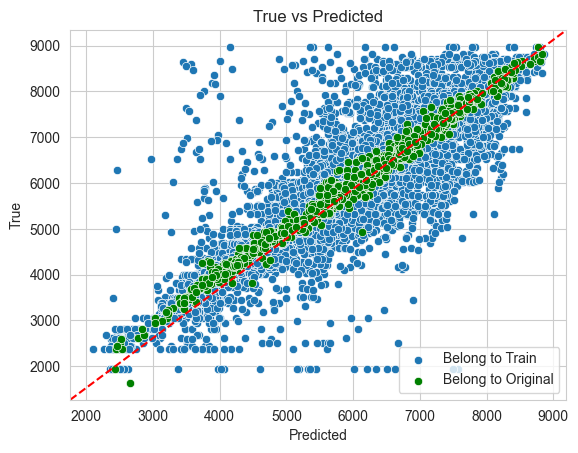

In [29]:
# Show pred vs true
graph_pred_vs_true(pipelinesLGB, eval_sets_LGB)

# Make Submission

In [30]:
preds = 0
for i in range(0, len(pipelinesCB)):
    preds += pipelinesCB[i].predict(df_test)
preds = preds / 5.0

In [31]:
preds

array([4268.97214594, 5887.13086869, 7280.43846637, ..., 6461.07826022,
       4401.84950452, 7197.55999616])

In [32]:
preds = post_processing_trick(preds)

In [33]:
preds

array([4278.76321, 5882.96562, 7284.81478, ..., 6461.67087, 4393.52743,
       7198.42285])

In [34]:
submission = pd.DataFrame()
submission['yield'] = preds
submission.index += 15289

In [35]:
submission

,yield
15289,4278.76321
15290,5882.96562
15291,7284.81478
15292,4710.85865
15293,3822.98167
...,...
25478,5393.56434
25479,5636.30874
25480,6461.67087
25481,4393.52743


In [36]:
submission.to_csv("submission.csv", index=True, header=True, index_label="id")